<header style="padding:10px;background:#f9f9f9;border-top:3px solid #00b2b1"><img id="Teradata-logo" src="https://www.teradata.com/Teradata/Images/Rebrand/Teradata_logo-two_color.png" alt="Teradata" width="220" align="right" />

<p style = 'font-size:28px;font-family:Arial;color:#E37C4D'><b>Classification Using ClearScape Analytics Text Preparation and Naive Bayes Classification Functions</b></p>
</header>
<hr>

<br>

<b style = 'font-size:24px;font-family:Arial;color:#E37C4D'>Utilize Native ClearScape Analytics functions for Text Processing and Analytics for performance at extreme scale</b>

<p style = 'font-size:16px;font-family:Arial'>Naive Bayes Classifiers are a collection of classification algorithms based on Bayes' Theorem. It is not a single algorithm but a family of algorithms where all of them share a common principle, i.e. every pair of features being classified is independent of each other.</p>

<p style = 'font-size:16px;font-family:Arial'>For text classifcation, a very simple way to understand how this type of classification works is that the algorithm can calculate the probability of appearance of a word or a sequence of words of length n (also known as n-gram) within the words of a text or the words of a category.  Prior to classification, text needs to be processed into these grams (or "tokens").</p>

<p style = 'font-size:16px;font-family:Arial'>Many text processing and classification tools exist across a variety of programming languages, but only Vantage provides the capability to perfom these tasks with the degree of performance and scale required by the modern enterprise.  Furthermore, text preparation and analytics <b>pipelines</b> can be built that can automate the usage of these powerful algorithms seamlessly to the business.</p> 

<hr>

<b style = 'font-size:24px;font-family:Arial;color:#E37C4D'>Live Demonstration</b>

<p style = 'font-size:16px;font-family:Arial'>The data for this demonstration consists of Amazon Fine Foods Reviews, which can be found <a href = 'https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews'>here</a>.  The Demonstration below consists of the following steps:</p>

<ol style = 'font-size:16px;font-family:Arial'>
    <li>Data Preparation; including ratings categorization and tokenization</li>
    <li>Model Training; create a Naive Bayes Text Classification Model using Training data</li>
    <li>Scoring and Evaluation; make a prediction using test data, and evaluate the result</li>
    </ol>
    
<img src = 'Flow_Diagram_TextClassifier.png' width = 100%>

<hr>
<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 1 - Data Preparation</b></p>

<p style = 'font-size:16px;font-family:Arial'>Here, we will inspect the original data set, and perform various preparation tasks.</p>


<ol style = 'font-size:16px;font-family:Arial'>
    <li>Inspect the rows of the table</li>
    <li>Transform the numeric rating to a categorical value using <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Cleaning-Functions/Parsing-Data/TD_ConvertTo'>ConvertTo</a>, then verify the new column types using <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Data-Exploration-Functions/TD_ColumnSummary'>ColumnSummary</a></li>
    <li>Split the data into training and testing data sets</li>
    <li>Tokenize the data using <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Text-Analytic-Functions/TD_TextParser'>TextParser</a></li>
    </ol>
    

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Imports and Connection</p>

<p style = 'font-size:16px;font-family:Arial'>Import required packages and create a connection context to Vantage.</p>

In [1]:
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter = lambda *args, **kwargs: ""

import json
from teradataml import *


from IPython.display import display as ipydisplay

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# load vars json
with open('../../vars.json', 'r') as f:
    session_vars = json.load(f)

# Create the SQLAlchemy Context
host = session_vars['environment']['host']
username = session_vars['hierarchy']['users']['business_users'][1]['username']
password = session_vars['hierarchy']['users']['business_users'][1]['password']

eng = create_context(host=host, username=username, password=password)

eng.execute(f'''SET SESSION COMPUTE GROUP {session_vars['hierarchy']['users']['business_users'][1]['compute_group']}''')

# confirm connection
print(eng)

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>1.1 - Inspect the Data</p>

<p style = 'font-size:16px;font-family:Arial'>Create a "Virtual Dataframe" which is a remote representation of the data set.  This allows us to operate on the data at remove/at scale using common pandas and python syntax.  <b>ColumnSummary</b> is a powerful in-built function for describing whole-data-set statistical information.</p>

In [3]:
tdf_reviews = DataFrame('"demo_ofs"."Amazon_Fine_Foods_Reviews"')

In [4]:
ipydisplay(tdf_reviews.shape)
ipydisplay(tdf_reviews.head(5))

(568453, 3)

doc_id,rating,review
4,2,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The flavor is very medicinal.
6,4,"I got a wild hair for taffy and ordered this five pound bag. The taffy was all very enjoyable with many flavors: watermelon, root beer, melon, peppermint, grape, etc. My only complaint is there was a bit too much red/black licorice-flavored pieces (just not my particular favorites). Between me, my kids, and my husband, this lasted only two weeks! I would recommend this brand of taffy -- it was a delightful treat."
5,5,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."
3,4,"This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar. And it is a tiny mouthful of heaven. Not too chewy, and very flavorful. I highly recommend this yummy treat. If you are familiar with the story of C.S. Lewis' ""The Lion, The Witch, and The Wardrobe"" - this is the treat that seduces Edmund into selling out his Brother and Sisters to the Witch."
2,1,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."


In [5]:
from teradataml import ColumnSummary

res = ColumnSummary(data = tdf_reviews, target_columns = ['doc_id', 'rating', 'review'])
res.result

ColumnName,Datatype,NonNullCount,NullCount,BlankCount,ZeroCount,PositiveCount,NegativeCount,NullPercentage,NonNullPercentage
review,VARCHAR(21500) CHARACTER SET LATIN,568453,0,0,None,None,None,0.0,100.0
rating,INTEGER,568453,0,None,0,568453,0,0.0,100.0
doc_id,INTEGER,568453,0,None,0,568453,0,0.0,100.0


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>1.2 Transform a numeric column to categorical</p>

<p style = 'font-size:16px;font-family:Arial'>Use <b>ConvertTo</b> to transform the "rating" column from INTEGER to VARCHAR data type.  Note ConvertTo can accept multiple columns, column ranges as TargetColumns and TargetDataType.  Next, check column dtypes and database datatype.</p>

In [6]:
from teradataml import ConvertTo

res = ConvertTo(data = tdf_reviews, 
                target_columns = 'rating', 
                target_datatype = 'VARCHAR(charlen=11,charset=UNICODE,casespecific=NO)')


In [7]:
ipydisplay(res.result.dtypes)
ipydisplay(res.result.tdtypes)

COLUMN NAME,TYPE
doc_id,int
rating,str
review,str


COLUMN NAME,TYPE
doc_id,INTEGER()
rating,"VARCHAR(length=11, charset='UNICODE')"
review,"VARCHAR(length=21500, charset='LATIN')"


<hr>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Test/Train Split</p>

<p style = 'font-size:16px;font-family:Arial'>Extraordinarily fast "Sample" function can split the data into multiple data sets in seconds.  Use Matplotlib to plot the distributions of each split.</p>

In [8]:
tdf_samples = res.result.sample(frac = [0.02, 0.08])
copy_to_sql(tdf_samples[tdf_samples['sampleid'] == 2], table_name = 'text_train', schema_name = 'demo_ofs', if_exists = 'replace')
copy_to_sql(tdf_samples[tdf_samples['sampleid'] == 1], table_name = 'text_test', schema_name = 'demo_ofs', if_exists = 'replace')

tdf_train = DataFrame('"demo_ofs"."text_train"')
tdf_test = DataFrame('"demo_ofs"."text_test"')

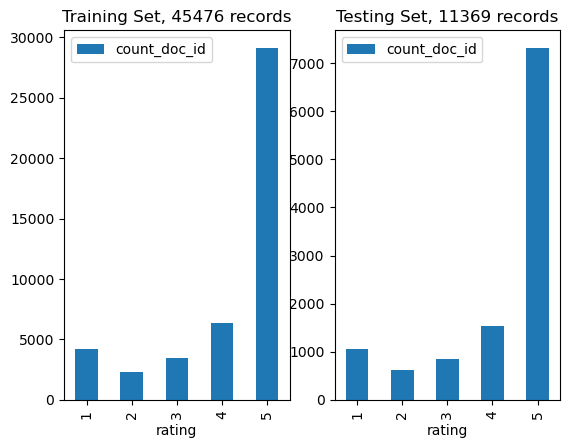

In [9]:
fig, (ax1, ax2) = plt.subplots(ncols = 2)

df1 = tdf_train.groupby('rating').count().to_pandas(index_column = 'rating')[['count_doc_id']]
df1.sort_index().plot(kind = 'bar', ax = ax1)
ax1.set_title(f'Training Set, {str(df1.sum()[0])} records')
df2 = tdf_test.groupby('rating').count().to_pandas(index_column = 'rating')[['count_doc_id']]
df2.sort_index().plot(kind = 'bar', ax = ax2)
ax2.set_title(f'Testing Set, {str(df2.sum()[0])} records')

plt.show()

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>1.4 - Use TextParser to prepare text for analysis</p>

<p style = 'font-size:16px;font-family:Arial'>The <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Text-Analytic-Functions/TD_TextParser'>TextParser</a> Function performs the following actions:</p>

<ul style = 'font-size:16px;font-family:Arial'>
    <li>Splits the text in the specified column into "tokens" based on a delimeter and creates a row for each token</li>
    <li>Optionally removes select punctuation</li>
    <li>Optionally converts the text to lowercase</li>
    <li>Removes predefined "Stop Words" from the text</li>
    <li>Performs "Stemming" operations to modify the token to its root form</li>
    </ul>

<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Stop Words</p>
<p style = 'font-size:16px;font-family:Arial'>Stop Words are common words that don't provide much meaning, and are normally dropped from text prior to analysis or processing.  Common English Stop Words include "a", "the", "and", "of", etc.  For purposes of this demonstration, a Stop Words table has been created using the open-source Natural Language Toolkit (NLTK) <a href = 'https://gist.github.com/sebleier/554280'>list of stopwords</a>.</p>

In [10]:
tdf_stopwords = DataFrame('"demo"."stop_words"')
tdf_stopwords.head(5)

word
above
again
after
about
a


In [11]:
from teradataml import TextParser

train_tokens = TextParser(data = tdf_train, 
                          object = tdf_stopwords, 
                          punctuation="!#$%&()*+<>\",-./:;?@\\^_`{|}~''",
                          delimiter=None,
                          text_column = 'review', 
                          remove_stopwords = True,
                          accumulate = ['doc_id', 'rating'])
train_tokens.result.head(5)

doc_id,rating,token
14,4,fresh
14,4,packed
14,4,twizzlers
14,4,came
14,4,delicious


<hr>
<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 2 - Model Training</b></p>

<p style = 'font-size:16px;font-family:Arial'>The <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Text-Analytic-Functions/TD_NaiveBayesTextClassifierTrainer'>NaiveBayesTextClassifierTrainer</a> Function takes the table of tokens, which retain their original rating id (id) and rating score (categorical from 1 to 5) as input, and writes out a model table containing the probability of each token's category(Score).  Function parameters include:</p>


<ul style = 'font-size:16px;font-family:Arial'>
    <li>Column containing tokens</li>
    <li>Column containing categories</li>
    <li>Model Type - either Multinomial or Bernoulli.  Bernoulli is better for binary classification, where Multinonial is better for multiple classes</li>
    </ul>

In [12]:
from teradataml import NaiveBayesTextClassifierTrainer, NaiveBayesTextClassifierPredict

model = NaiveBayesTextClassifierTrainer(data = train_tokens.result, 
                                        doc_category_column = 'rating', 
                                        token_column = 'token', 
                                       model_type = 'Multinomial')

model.model_data

token,category,prob
0,2,8.515990409684646e-05
0004,1,8.471309791563422e-06
01014,1,8.471309791563422e-06
02,1,1.6942619583126844e-05
03,2,1.3101523707207148e-05
03,5,5.867811616422831e-06
02,5,2.5147764070383563e-06
000,1,4.235654895781711e-05
½,4,1.4243350491822892e-05
½,3,9.287724414641169e-06


<hr>
<p style = 'font-size:20px;font-family:Arial;color:#E37C4D'><b>Step 3 - Model Scoring and Evaluation</b></p>

<p style = 'font-size:16px;font-family:Arial'>Execute a testing prediction using the split data above.  Evaluate the model by creating a confusion matrix with the <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Advanced-SQL-Engine-Analytic-Functions/TD_ClassificationEvaluator'>ClassificationEvaluator</a> Function.</p>


<ol style = 'font-size:16px;font-family:Arial'>
    <li>Tokenize the Testing data that was split above - use the same function parameters</li>
    <li>Execute <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Text-Analytic-Functions/NaiveBayesTextClassifierPredict'>NaiveBayesTextClassifierPredict</a> using the model built above</li>
    <li>Execute <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Advanced-SQL-Engine-Analytic-Functions/TD_ClassificationEvaluator'>TD_ClassificationEvaluator</a> and pass the actual classification and the predicted value</li>
    <li>Investigate the Confusion Matrix and additional metrics values</li>
    </ol>

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>3.1 Tokenize the Testing data</p>

In [13]:
test_tokens = TextParser(data = tdf_test, object = tdf_stopwords, punctuation="!#$%&()*+<>\",-./:;?@\\^_`{|}~''",
                         delimiter=None,
                text_column = 'review', remove_stopwords = True,
                 accumulate = ['doc_id', 'rating'])

test_tokens.result

doc_id,rating,token
25302,4,drink
16405,2,lots
16405,2,problems
42452,5,good
484549,5,jam
484549,5,good
42452,5,luck
25302,4,regular
53963,5,chicken
53963,5,bought


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>3.2 Execute the Prediction Function</p>

<p style = 'font-size:16px;font-family:Arial'>The <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Text-Analytic-Functions/NaiveBayesTextClassifierPredict'>NaiveBayesTextClassifierPredict</a> Function takes the model built using TD_NaiveBayesClassifierTrainer as input table, and outputs likelihood and probability information per document.  Additional parameters include (but are not limited to):</p>


<ul style = 'font-size:16px;font-family:Arial'>
    <li>Trained model information</li>
    <li>Input data table information</li>
    <li>Various output parameters</li>
    </ul>

In [14]:
pred = NaiveBayesTextClassifierPredict(newdata = test_tokens.result, 
                                       object = model.model_data,
                                       accumulate = ['rating'],
                                       input_token_column = 'token',
                                       responses = ['1','2','3','4','5'],
                                       output_prob = True,
                                       model_prob_column = 'prob',
                                       model_category_column = 'category',
                                       model_token_column = 'token', 
                                       doc_id_columns = 'doc_id',
                                       newdata_partition_column = 'doc_id')
pred.result

doc_id,prediction,loglik_1,loglik_2,loglik_3,loglik_4,loglik_5,prob_1,prob_2,prob_3,prob_4,prob_5,rating
1034,5,-189.118200360848,-192.38555024713574,-191.0965716855945,-185.7481548573389,-178.19617061364647,1.8046191251898067e-05,6.876912992102492e-07,2.495685215056368e-06,0.0005247805394212554,0.9994539898928126,5
761,5,-496.03377505191327,-489.58712644990476,-486.66279714886406,-479.6821912480426,-478.79070993168466,2.301836033908119e-08,1.4515042073800855e-05,0.0002702952275911471,0.2907213996304398,0.7089937670815349,5
811,5,-244.07544365341474,-245.96622800248954,-243.19888149201975,-238.24101294939538,-231.26523234868307,2.730147810305936e-06,4.1212499143432553e-07,6.559523165285348e-06,0.0009333557776794565,0.9990569424263537,5
748,4,-1647.3135357677027,-1662.0219366304273,-1651.8937406265513,-1614.7129802803051,-1620.198790674248,6.917706614343722e-15,2.8325971051667608e-21,7.09258326662427e-17,0.9958719370477832,0.004128062952209845,3
257,5,-233.00985611328016,-230.51358029792664,-225.20718650743717,-221.47864539252566,-215.77931835986826,3.2763164446104824e-08,3.9765335740661273e-07,8.017559573577378e-05,0.0033367758016924357,0.99658261818605,5
580,5,-54.7876320271664,-54.70683643045639,-55.054355910185286,-51.14752418011189,-46.04824578112904,0.00015910878214913128,0.0001724976700556414,0.00012185895260648456,0.006061399420026721,0.993485135175162,5
135,5,-74.10190271224418,-73.28183309601297,-73.42650406828096,-72.08359883230695,-69.48011972797455,0.008738495141003206,0.019842133084369433,0.01716953578499018,0.06576198094256283,0.8884878550470745,5
313,5,-102.48864524448463,-105.26385156072591,-104.22827170586615,-103.18645906039602,-101.07714826848651,0.17130074431503453,0.010678308428851514,0.030078008467746768,0.08525160427876263,0.7026913345096046,1
203,5,-99.2407349776851,-104.70219624728207,-103.48005192441966,-100.80433485046478,-94.98763747087828,0.013976055460069574,5.936112497681356e-05,0.00020149889012512838,0.002926320021486333,0.9828367645033422,5
544,5,-282.55561021585595,-282.15855954894664,-283.17165968934967,-280.0300118534284,-274.2276413499545,0.00024075906250776551,0.0003581125633316327,0.0001300276628914356,0.0030090962250933074,0.996262004486176,1


<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>3.3 - Evaluate the Model Accuracy</p>

<p style = 'font-size:16px;font-family:Arial'>Evaluate the model by creating a confusion matrix with the <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Advanced-SQL-Engine-Analytic-Functions/TD_ClassificationEvaluator'>ClassificationEvaluator</a> Function.</p>


<ol style = 'font-size:16px;font-family:Arial'>
    <li>Execute <a href = 'https://docs.teradata.com/r/Teradata-VantageTM-Analytics-Database-Analytic-Functions-17.20/Advanced-SQL-Engine-Analytic-Functions/TD_ClassificationEvaluator'>ClassificationEvaluator</a> and pass the actual classification and the predicted value</li>
    <li>Investigate the Confusion Matrix and additional metrics values</li>
    <li>Alternatively, create a heatmap using open-source tools</li>
    </ol>

In [15]:
from teradataml import ClassificationEvaluator

acc = ClassificationEvaluator(data = pred.result[['prediction','rating']], num_labels = 5,
                              observation_column = 'rating', prediction_column = 'prediction')

In [16]:
ipydisplay(acc.result)
ipydisplay(acc.output_data)

SeqNum,Prediction,Mapping,CLASS_1,CLASS_2,CLASS_3,CLASS_4,CLASS_5,Precision,Recall,F1,Support
4,5,CLASS_5,311,278,379,983,6663,0.7735082423960994,0.9106191061910619,0.8364823300483335,7317
3,4,CLASS_4,68,90,205,431,420,0.35502471169686983,0.280416395575797,0.31334060341693926,1537
0,1,CLASS_1,594,112,95,60,150,0.5875370919881305,0.5657142857142857,0.5764192139737991,1050
2,3,CLASS_3,54,84,153,56,62,0.3740831295843521,0.1804245283018868,0.24343675417661098,848
1,2,CLASS_2,23,53,16,7,22,0.4380165289256198,0.08589951377633712,0.14363143631436315,617


SeqNum,Metric,MetricValue
3,Micro-Recall,0.6943442695047938
5,Macro-Precision,0.5056339409182143
6,Macro-Recall,0.4046147659118737
7,Macro-F1,0.4226620675860092
9,Weighted-Recall,0.6943442695047938
10,Weighted-F1,0.6599033208580974
8,Weighted-Precision,0.651757008559462
4,Micro-F1,0.6943442695047938
2,Micro-Precision,0.6943442695047938
1,Accuracy,0.6943442695047938


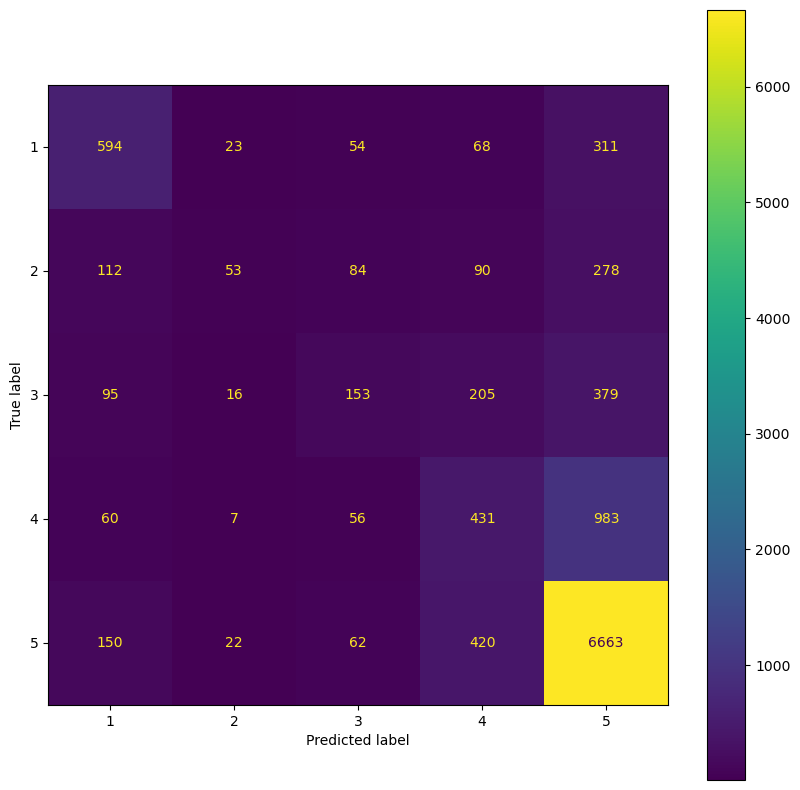

In [17]:
df_pred = pred.result.to_pandas()
cm = confusion_matrix(df_pred['rating'], df_pred['prediction'])
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['1', '2', '3', '4', '5'])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)

plt.show()

<hr>
<p style = 'font-size:18px;font-family:Arial;color:#E37C4D'>Cleanup</p>

In [18]:
db_drop_table('text_train', schema_name = 'demo_ofs')
db_drop_table('text_test', schema_name = 'demo_ofs')

True

In [19]:
remove_context()

True